In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

Goal: Create a made-up name generator!

What does it do? It predicts the most likely:
- starting character
- ending character
- next character in sequence
to predict new names.

In [3]:
torch.cuda.is_available()

False

In [3]:
words = open('names.txt', 'r').read().splitlines()

 ## Data Exploration

In [6]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

In [8]:
min(len(w) for w in words)

2

In [9]:
# Data exploration is so critical to this process, because it's the stage at which one comes
# to understand the structure of the data you're working with, and *how* you can use a ML model
# to exploit that structure.

# What we're doing now: Identifying consecutive chars, starting and ending chars, which will be the
# basic structure we identify in words for the moment.
b = {}
for w in words:
    # Make a fake starting and ending character to signify which pair of letters is the start and end
    # which we'll use later without having to treat starting and ending letters separately from
    # consecutive letters
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [10]:
sorted(b.items(),key = lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [11]:
# Now convert this to a torch 2-tensor 
# We replace the fake starting, ending characters with a single placeholder
# since .a means a comes first, a. means a comes last.
N = torch.zeros((27,27), dtype=torch.float32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['.'] = 26
itos = {i:s for s,i in stoi.items()}

In [12]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

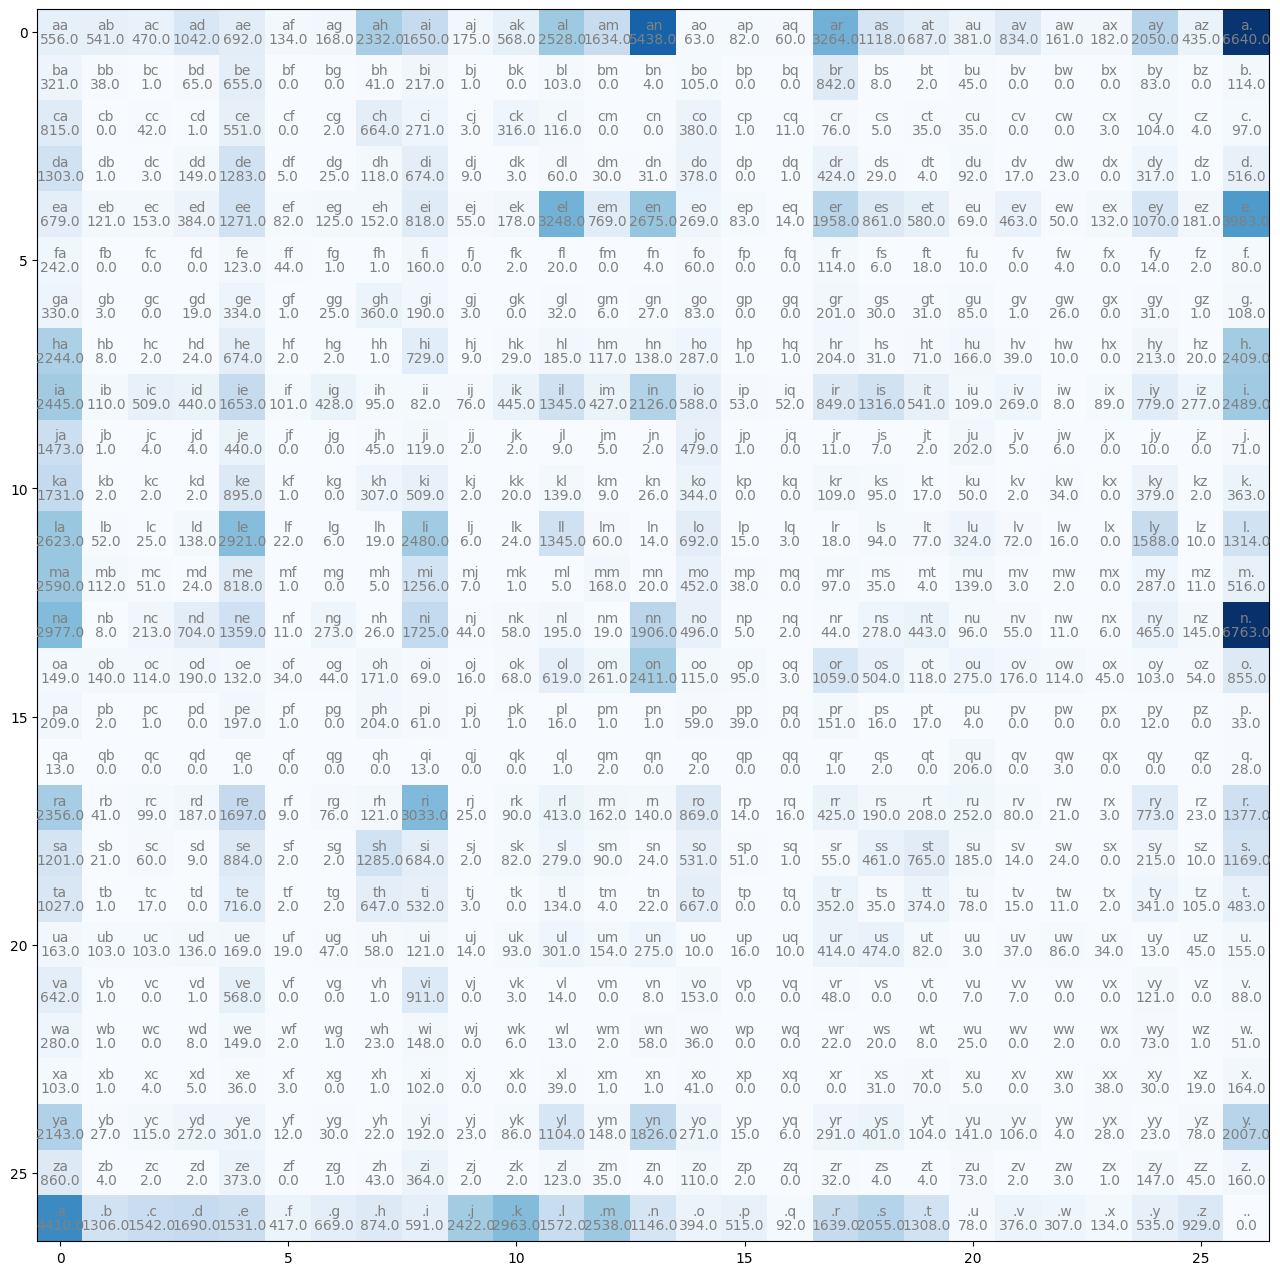

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr, ha="center", va="bottom", color='gray')
        plt.text(j,i,N[i,j].item(),ha="center",va="top",color='gray')

## A First Attempt At Prediction Using Bigrams

In [14]:
# Add 1 to N in order to assign a small but nonzero probability to words that currently have 0 probability:
P = (N+1).float()
# This operation is an example of broadcasting:
# Broadcasting rule: Each coordinate in the tensor must either:
# 1. Be equal, 2. One coordinate = 1, 3. One coordinate DNE
# The effect of the operation when a coordinate is 1: Extends coordinate to n by copying
# So the below actually works.why resampling is done
# The effect of the operation when a coordinate does not exist:
# Append a new coordinate of 1 dim to the beginning of the tensor, then apply above.
# In the below: keepdim=True turns the 27x27 tensor into a 27x1 tensor; if False, the effect
# when broadcasting is: 27x27 -> 27 -> 1x27, so incorrrectly divides the row values by the column values.
P /= P.sum(1, keepdims=True)
P

tensor([[1.6425e-02, 1.5983e-02, 1.3889e-02, 3.0756e-02, 2.0435e-02, 3.9809e-03,
         4.9835e-03, 6.8796e-02, 4.8685e-02, 5.1899e-03, 1.6779e-02, 7.4575e-02,
         4.8213e-02, 1.6039e-01, 1.8872e-03, 2.4475e-03, 1.7988e-03, 9.6279e-02,
         3.2997e-02, 2.0288e-02, 1.1264e-02, 2.4623e-02, 4.7771e-03, 5.3963e-03,
         6.0480e-02, 1.2857e-02, 1.9583e-01],
        [1.2051e-01, 1.4596e-02, 7.4850e-04, 2.4701e-02, 2.4551e-01, 3.7425e-04,
         3.7425e-04, 1.5719e-02, 8.1587e-02, 7.4850e-04, 3.7425e-04, 3.8922e-02,
         3.7425e-04, 1.8713e-03, 3.9671e-02, 3.7425e-04, 3.7425e-04, 3.1549e-01,
         3.3683e-03, 1.1228e-03, 1.7216e-02, 3.7425e-04, 3.7425e-04, 3.7425e-04,
         3.1437e-02, 3.7425e-04, 4.3039e-02],
        [2.2928e-01, 2.8098e-04, 1.2082e-02, 5.6196e-04, 1.5510e-01, 2.8098e-04,
         8.4293e-04, 1.8685e-01, 7.6426e-02, 1.1239e-03, 8.9070e-02, 3.2874e-02,
         2.8098e-04, 2.8098e-04, 1.0705e-01, 5.6196e-04, 3.3717e-03, 2.1635e-02,
         1.6859e-

In [15]:
# This is resampling our data using a bootstrapping method. Since our samples don't have any 
# structure to their data, and we're not doing a training/testing split, this is the simplest
# and most effective route (as opposed to k-folds)

# torch.multinomial: Returns tensor where each row contains num_samples
# indices sampled from multinomial distribution located in row of input
# Generator: result of sampling is deterministic so it agrees with Karpathy's distribution
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
itos[ix]

'n'

In [16]:
# Let's get our primitive model to print some new names.
g = torch.Generator().manual_seed(2147483647)
for i in range(0,10):
    ix = 26
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 26:
            break
    print(''.join(out))

ka.
kenen.
lyri.
ara.
gri.
beonaneiasaupide.
tah.
r.
anenoubd.
kanan.


In [17]:
# Conclusion to all this: Our bigram model sucks! Needs some gradient descent to be better.
# How to evaluate quality? Determine a loss function.
# Let's make a loss function!

In [18]:
# Loss function: -log likelihood function in predicting the o.g. names

In [19]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {prob:.4f}')
print(f'{-log_likelihood/n=}')

-log_likelihood/n=tensor(2.4544)


## Building a language model:

In [56]:
# Create training set of bigrams:
# xs: Inputs (1st char)
# ys: Outputs (2nd char)
xs, ys = [], []
for w in words[:1000]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
# Note .tensor is different from .Tensor: .tensor infers datatype and creates a tensor of the
# appropriate type, while .Tensor assumes the datatype is Float by default.
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [57]:
# To multiply probabilities, it won't make sense to multiply the indices. So use 
# a one-hot encoding:
# (by default, one_hot encodes as int vectors instead of float vectors)
xenc = torch.nn.functional.one_hot(xs, num_classes=27).float() 
print(ys.shape)
print(xenc.shape)

W = torch.randn((27,27), requires_grad=True)
# @ is multiplication in torch for some awful reason:
# (xenc @ W)

torch.Size([7000])
torch.Size([7000, 27])


In [58]:
# Now we build softmax:
def softmax(logits):
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdims=True)
    return probs

In [60]:
# Gradient descent:
for k in range(0,1000):
    # Forward Pass:
    probs = softmax(xenc @ W)
    # Adding W**2.mean() slightly uniformizes W: Same effect as adding 1 to the counts
    # in the prior section:
    loss = -probs[:,ys].log().mean() + 0.01*(W**2).mean()
    #Backward Pass:
    W.grad = None
    loss.backward()
    W.data += -10 * W.grad
    
    if k % 100 == 0:
        print(loss)


# for k in range(len(list(xenc[:,0]))):
#     # forward pass:
#     ypred = []

tensor(2.7471, grad_fn=<NegBackward0>)
tensor(2.7389, grad_fn=<NegBackward0>)
tensor(2.7345, grad_fn=<NegBackward0>)
tensor(2.7319, grad_fn=<NegBackward0>)
tensor(2.7301, grad_fn=<NegBackward0>)
tensor(2.7289, grad_fn=<NegBackward0>)
tensor(2.7280, grad_fn=<NegBackward0>)
tensor(2.7273, grad_fn=<NegBackward0>)
tensor(2.7267, grad_fn=<NegBackward0>)
tensor(2.7263, grad_fn=<NegBackward0>)


# Makemore Part 2: Multi-Layer Perceptron (MLP)

In [906]:
# Damn My Little Pony!
# The video for this uses a separate document, so I'm treating this as such:

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import time
import math
%matplotlib inline

In [88]:
# Following the architecture of Bengio, Ducharme, Vincent, Jauvin: 
# https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# To get i-th output, determined by: P(w_t = i | context), take as input:
# the n-character context window, embedded as vectors through some
# (presumably) learned embedding process for efficient and intelligent storage
# Put these characters through an activation function (they use tanh)
# And then softmax to obtain probabilities

In [81]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
# I was putting my own spin on it  by having '.' be 26, but 
# now that we're initializing lists with it, 0 is the better encoding:
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [118]:
# Now we have new stuff:
block_size = 3 # Context length; likely will want to adjust this
# This is how much past stuff our MLP can see
Xlst, Ylst = [], []
for w in words[:5]:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        Xlst.append(context)
        Ylst.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(Xlst)
Y = torch.tensor(Ylst)

In [135]:
# # Playing with tensor indexing:
# print(X.shape)
# print(Y.shape)
# print(C.shape)
# print(C[5]) # same as:
# print(C[[5],[0,1]])
# print(C[[5,6]])
# print(C[[0,1]])
# print(C[[5,6,5,6],[0,0,1,1]]) # flattens the 2x2 tensor into a 1x4 read down-right
# print(C[[5,6],[0,1]]) # Takes the diagonal of C[5,6]
# print(C[torch.tensor([[5,6],[0,1]])]) # Notably different from the above:
# # Its first 2x2 matrix is that of C[[5,6]], the second is that of C[[0,1]]
# print(torch.tensor([[5,6],[6,7],[7,8]]))
# print(C[torch.tensor([[5,6],[6,7],[7,8]])])
# print(torch.tensor([[5,6],[6,7],[7,8]]).shape)
# print(C[torch.tensor([[5,6],[6,7],[7,8]])].shape)
# # So if C is axb and M is mxn, C[M] is mxnxb: C[M][i] is an mxn matrix consisting of
# # the ith row of M used as indices for the entries of C
# # Hence, if M[0] = [2,3], C[2] = [4,5], C[3] = [6,7], then C[M][0] = [[4,5],[6,7]]

In [91]:
# When initializing C randomly, C[n] gives the same result as:
# F.one_hot(torch.tensor(n), num_classes=27).float() @ C
# So there's no need to explicitly one-hot encode the characters into C;
# It happens "automatically"
# C[X] embeds X into C
C = torch.randn((27,2))
emb = C[X]
emb.shape

tensor([-0.0385,  0.6032])

In [138]:
# 6,100 because we want 100 layers to our MLP, 6 for 1x2 embeddings of each
# of the 3 characters in the 3-length block of context
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [144]:
# Want to do: emb @ W1 + b1
# But won't work because trying to multiply a 3x2 component by a 6 component
# Need to flatten.
# First try: torch.cat([emb[:,i,:] for i in range(0,block_size)])
# But there's something easier: torch.cat(torch.unbind(emb,1),1)
# ... But actually there's something easier: 
# If T contains a total of axbxc items, then T.view(a,b,c) turns it into an axbxc tensor
# Regardless of what the shape of T was before.
# So do:
# (-1 equiv to "whatever's remaining")
h = emb.view(-1,6) @ W1 + b1 # Take care with this adding b1: b1 gets broadcast, but it's right.
h = torch.tanh(h)

In [160]:
h.shape
# Now create the final layer:
W2 = torch.randn((100,27),requires_grad=True)
b2 = torch.randn(27)

In [161]:
# Now we build softmax:
def softmax(logits):
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdims=True)
    return probs

In [162]:
print(probs.shape)
print(Y.shape)
# Current probabilities for the correct character:


torch.Size([32, 27])
torch.Size([32])


In [168]:
# Gradient descent (mostly copied from before):
for k in range(0,10000):
    # Forward Pass:
    logits = h @ W2 + b2
    # probs = softmax(logits)
    # loss = -probs[torch.arange(32), Y].log().mean()    
    loss = F.cross_entropy(logits, Y) # Same computation, but torch does it better
    
    #Backward Pass:
    W2.grad = None
    loss.backward()
    W2.data += -0.1 * W2.grad
    
    if k % 1000 == 0:
        print(loss)

tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)
tensor(0.2519, grad_fn=<NegBackward0>)


# Makemore Parts 2 and 3: Cleaned Up and Functional
## Optimizing Hyperparameters, Normalizing Initialization, BatchNorm 

In [169]:
# ---------------- Cleaning up the above: ----------------

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import time
import math
%matplotlib inline

In [929]:
# Split data into three parts: Training, validation, and testing
# Validation is for tuning hyperparameters;
# Be cautious running too long on validation or testing, else you
# fit to the new data too much! 

def conv(words):
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    
    return stoi, itos

stoi, itos = conv(words)


def build_dataset(words, block_size):
    Xlst, Ylst = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            Xlst.append(context)
            Ylst.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(Xlst)
    Y = torch.tensor(Ylst)
    return X, Y

# trn: portion to be training set
# devn: portion to be validation set
def split_dataset(words, block_size, trn, devn, seed=None):
    random.Random(seed).shuffle(words)
    n1 = int(trn*len(words))
    n2 = int((trn+devn)*len(words))
    Xtr, Ytr = build_dataset(words[:n1], block_size)
    Xdev, Ydev = build_dataset(words[n1:n2], block_size)
    Xte, Yte = build_dataset(words[n2:], block_size)
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [930]:
def initialize_parameters(Hyperparameters, g=None):
    [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity] = Hyperparameters
    C = torch.randn((27,Cdims),generator=g) #<--- Input layer where values are embedded
    W1 = torch.randn((Cdims*block_size, layers), generator=g) / (0.5 * block_size * Cdims)**0.5 #<--- Hidden layers of MLP weights
    # See above for why / (f'(0), block_size, Cdims)**0.5, f'(0) = Phi(0) = 0.5, hence...

    # Commented out b1 because batch normalization removes bias before normalization, then adds it back in:
    # b1 = torch.randn(layers, generator=g) * 0.01 #<--- Bias for hidden layers
    
    W2 = torch.randn((layers,27), generator=g) * 0.01 #<--- Output layer of probabilities
    b2 = torch.randn(27, generator=g) * 0 #<--- Bias for output layer

    # For batch normalization:
    normscale = torch.ones(layers)
    normbias = torch.zeros(layers)

    normscale_running = torch.ones(layers)
    normbias_running = torch.zeros(layers)
    
    parameters = [C, W1, W2, b2, normscale, normbias]
    statistics =  [normscale_running, normbias_running]
    for p in parameters:
        p.requires_grad = True
    return parameters, statistics

In [931]:
# How to find best descentspeed / learning rate?
# What if you search over them?!
# Per video: A good lower bound seems to be .001, upper bound 1
# lre = torch.linspace(-3,0,1000)
# lrs = 10**lre
# lossi = []
# lri = []

# I didn't really believe Karpathy because I thought that maybe the best
# learning rate might depend on how much we've already learned, so I tried
# iterating (slowly) over the different learning rates, re-initializing 
# all of the tensors each time to compare more accurately:
# for j in range(0,100):
#     C = torch.randn((27,Cdims),generator=g)
#     W1 = torch.randn((Cdims*block_size, layers), generator=g)
#     b1 = torch.randn(layers, generator=g)
#     W2 = torch.randn((layers,27), generator=g)
#     b2 = torch.randn(27, generator=g)
#     parameters = [C, W1, b1, W2, b2]
#     for p in parameters:
#         p.requires_grad = True
# (result: it didn't make a dramatic difference)
# Why doesn't it matter? Because at this stage, trying to just get a rough estimate, and it's so much faster
# than re-initializing every time. Consequently, you can make much faster progress and then do the same process
# again on a tigher bound to fine-tune initial step size. 

In [981]:
# Stochastic gradient descent
def stochgrad(parameters, statistics, Hyperparameters):
    [C, W1, W2, b2, normscale, normbias] = parameters
    [normscale_running, normbias_running] = statistics
    [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity] = Hyperparameters
    lossi = []
    lri = []
    stepi = []
    
    sizemod = max(int(math.log10(steps))-3,1)
    for j in range(0,sizemod):
        lrmult = 10**(-j)
        
        for k in range(0,steps//sizemod):
            # Make mini-batches to iterate over instead:
            # (batch_size,) because needs to be a tuple for the size
            ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 
            # C[X] consists of the "words" in X embedded into the learned embedding space
            # C, which contains embeddings of each character and how they're associated to each other
            emb = C[Xtr[ix]] # (batch_size, block_size, Cdims) tensor

            # Linear layer:
            embcat = emb.view(-1,(block_size * Cdims)) # Concatenate submatrices of C into vectors to multiply
            hpreact = embcat @ W1 # Initial value of h, pre-activation

            # Batch Normalization:
            # -------------------------------------------------------------------------
            # Track the normalization values:
            normscalei = hpreact.std(0, keepdim=True)
            normbiasi = hpreact.mean(0, keepdim=True)

            # Normalization layers:
            normedh = (hpreact - normbiasi) / (normscalei + 0.00001) # Normalize it, add an epsilon>0 in case no-variance batch occurs
            normedh = normscale * normedh + normbias # Modify by learned scaling and bias

            with torch.no_grad():
                normscale_running = 0.999 * normscale_running + 0.001 * normscalei
                normbias_running = 0.999 * normbias_running + 0.001 * normbiasi
            # --------------------------------------------------------------------------

            
            # Activation layers: 
            h = F.gelu(normedh) # (total combinations, layers) tensor
            
            
            
            # Forward Pass:
            logits = h @ W2 + b2
            
            loss = F.cross_entropy(logits, Ytr[ix]) + creativity*(W2**2).mean() * lrmult
            #Backward Pass:
            for p in parameters:
                p.grad = None
            loss.backward()
                
            for p in parameters:
                p.data += -descentspeed * p.grad *lrmult
            
            # Track loss performance
            # lri.append(lre[k])
            lossi.append(loss.item())
            stepi.append(k)
            
            if k % 10000 == 0:
                print(loss.item())
            
            # Note that stochastic gradient descent doesn't converge as monotonically as 
            # ordinary gradient descent, because sometimes it sees new batches that throw things off
    
    parameters = [C, W1, W2, b2, normscale, normbias]
    statistics = [normscale_running, normbias_running]
    
    return parameters, statistics, loss, lossi, stepi



In [955]:
# Check loss:
@torch.no_grad() # Disables computing gradients in anticipation of backward pass
def checkloss(X, Y, parameters, statistics, Hyperparameters):
    [C, W1, W2, b2, normscale, normbias] = parameters
    [normscale_running, normbias_running] = statistics
    [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity] = Hyperparameters
    
    emb = C[X] # (total combinations, block_size, Cdims) tensor
    
    embcat = emb.view(-1,(block_size * Cdims)) # Concatenate submatrices of C into vectors to multiply
    hpreact = embcat @ W1 # Initial value of h, pre-activation
    
    normedh = (hpreact - normbias_running) / (normscale_running + 0.00001) # Normalize it
    normedh = normscale * normedh + normbias # Modify by learned scaling and bias
    
    h = F.gelu(normedh) # (total combinations, layers) tensor
    
    logits = h @ W2 + b2  
    loss = F.cross_entropy(logits, Y) + creativity*(W2**2).mean()
    
    return loss

In [956]:
# Generate from the model:

def generate(num, parameters, statistics, Hyperparameters, g=None):
    [C, W1, W2, b2, normscale, normbias] = parameters
    [normscale_running, normbias_running] = statistics
    [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity] = Hyperparameters

    for k in range(num):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]
            
            embcat = emb.view(1,-1)
            hpreact = embcat @ W1 # Initial value of h, pre-activation
            
            normedh = (hpreact - normbias_running) / (normscale_running + 0.00001) # Normalize it
            normedh = normscale * normedh + normbias # Modify by learned scaling and bias
            
            h = F.gelu(normedh) # (total combinations, layers) tensor
            
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
    
        print(''.join(itos[i] for i in out))

In [982]:
g = torch.Generator()#.manual_seed(2147483647)
block_size = 4
Cdims = 8
layers = 200
descentspeed = 0.1 # <--- In practice, want to decay the learning rate in later iterations
steps = 300000
# stages of training to fine-tune better as loss gets closer to true value
batch_size = 64
creativity = 0.0001
Hyperparameters = [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity]


In [958]:
stoi, itos = conv(words)
Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_dataset(words, block_size, 0.8, 0.1)
parameters, statistics = initialize_parameters(Hyperparameters, g=g)
[C, W1, W2, b2, normscale, normbias] = parameters
[normscale_running, normbias_running] = statistics

In [959]:
# Plots to see how frequently do extreme values of h occur:
# Don't want too much white space, because then activation functions aren't *doing* anything--
# A dead neuron can cause issues. 

# print(W1.shape)
# print(emb.view(-1,(block_size * Cdims)).shape)
ix = torch.randint(0, Xtr.shape[0], (batch_size,)) 
emb = C[Xtr[ix]]
h = F.gelu(emb.view(-1,(block_size * Cdims)) @ W1 + b1)
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

print(h.shape)
print(h.mean(0, keepdim=True).shape)
print(h.std(0, keepdim=True).shape)
# Normalize by:
h = (h - h.mean(0, keepdim=True))/ h.std(0, keepdim=True) #<--- However, this doesn't produce a desireable outcome!
# Why? Because too strong of normalization just centers the input into the activation function too close around 0.
# Need a model with the capacity to understand extremal values. So introduce scaling and shifting parameters
# that are also learned by the model. Each step of stochastic gradient descent over them produces estimates

torch.Size([64, 200])
torch.Size([1, 200])
torch.Size([1, 200])


In [960]:
# plt.hist(h.view(-1).tolist(), 50);

In [961]:
print(Xtr.shape[0]) # <--- Total combinations
print(sum(p.nelement() for p in parameters)) # <--- Total number of parametersleft-align cell jupyter notebook

182692
12443


In [962]:
# Testing Cdims Hyperparam:
# for i in range(2,12,1):
#     Cdims = i
#     Hyperparameters = [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity]
#     parameters = initialize_parameters(Hyperparameters, g=g)
#     parameters, loss, lossi, stepi = stochgrad(parameters, Hyperparameters)
#     print(checkloss(Xtr, Ytr, parameters, Hyperparameters))
#     print(checkloss(Xdev, Ydev, parameters, Hyperparameters))
# Based on 50k steps for each, it seems like Cdim=8 or 9 were optimal; choosing 8 since simplicity is better.

# Same thing but for layers:
# for i in range(60,600,20):
#     layers = i
#     Hyperparameters = [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity]
#     parameters = initialize_parameters(Hyperparameters, g=g)
#     parameters, loss, lossi, stepi = stochgrad(parameters, Hyperparameters)
#     print(i)
#     print(checkloss(Xtr, Ytr, parameters, Hyperparameters))
#     print(checkloss(Xdev, Ydev, parameters, Hyperparameters))
# Hard to make a conclusive decision about layers given the results. 
# I found 120, 220, and 500 to give the best results relative to their sizes, but their neighbors didn't
# necessarily reflect this, so I'm interpreting it to be essentially random after a certain point.
# 100 definitely seems like too few, 500 definitely seems like too many. Going with 200 as a safe middle point.

# Same thing but for batch sizes relative to time taken and # steps:
# for i in range(3,10):
#     batch_size = 2**i
#     steps = 20000//i

#     start_time = time.time()
    
#     Hyperparameters = [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity]
#     parameters = initialize_parameters(Hyperparameters, g=g)
#     parameters, loss, lossi, stepi = stochgrad(parameters, Hyperparameters)
#     print(i)
#     print(checkloss(Xtr, Ytr, parameters, Hyperparameters))
#     print(checkloss(Xdev, Ydev, parameters, Hyperparameters))
#     print(start_time - time.time())
# i=6 was the fastest, i=8 produced most accurate results, although the specific accuracy didn't
# change very much between i=5 and i=9, while the time doubled with i=8.
# Going with i=6 (batch_size = 64) since the time improvements were significant but accuracy
# improvements were not

# Lastly, same thing but for context window:
# for i in range(2,9):
#     block_size = i

#     start_time = time.time()
    
#     Hyperparameters = [block_size, Cdims, layers, batch_size, descentspeed, steps, creativity]
#     Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_dataset(words, block_size, 0.8, 0.1)
#     parameters = initialize_parameters(Hyperparameters, g=g)
#     parameters, loss, lossi, stepi = stochgrad(parameters, Hyperparameters)
#     print(i)
#     print(checkloss(Xtr, Ytr, parameters, Hyperparameters))
#     print(checkloss(Xdev, Ydev, parameters, Hyperparameters))
#     print(time.time() - start_time)
# 4 seems to be the best, followed by 6 and then 5. Surprisingly the different context window sizes
# didn't seem to make as big of a difference in time taken as expected.

In [983]:
parameters, statistics, loss, lossi, stepi = stochgrad(parameters, statistics, Hyperparameters)

1.9165297746658325
1.9533873796463013
1.9580477476119995
2.1434123516082764
2.116366147994995
2.261557102203369
2.0735297203063965
2.108672618865967
1.6643891334533691
1.9013574123382568
1.8101508617401123
2.1414103507995605
2.030125141143799
2.0703506469726562
2.18463134765625
2.159102439880371
1.9583230018615723
1.9977819919586182
2.1930487155914307
1.9625588655471802
2.155719518661499
2.1651408672332764
2.139453172683716
1.9114210605621338
2.2460873126983643
1.7797671556472778
1.7384270429611206
1.9544868469238281
2.0622475147247314
2.1732916831970215


In [984]:
[C, W1, W2, b2, normscale, normbias] = parameters
[normscale_running, normbias_running] = statistics
# print(normscale, normbias, normscale_running, normbias_running)

1.848593831062317


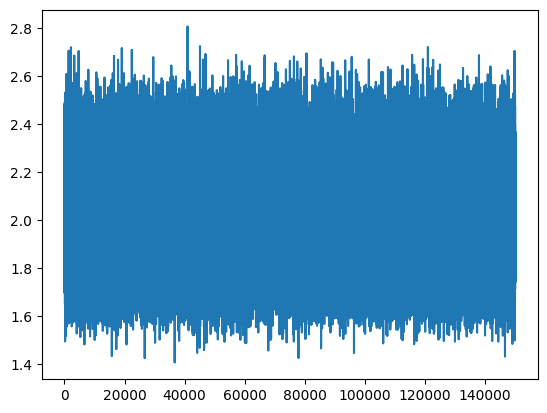

In [985]:
print(loss.item())
# print(lri, lossi)
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)

In [990]:
print(checkloss(Xtr, Ytr, parameters, statistics, Hyperparameters))
print(checkloss(Xdev, Ydev, parameters, statistics, Hyperparameters))
print(checkloss(Xte, Yte, parameters, statistics, Hyperparameters))

# Best values obtained:
# Training loss: 1.985
# Validation loss: 2.0695
# Testing loss: 2.0509
# E01 complete! 
# I didn't see there were exercises in the description of makemore parts 1 and 2
# until later, so I've skipped those from part 1 and question 2 from part 2 as they feel less necessary.

tensor(1.9850)
tensor(2.0695)
tensor(2.0509)


In [987]:
generate(20, parameters, statistics, Hyperparameters, g=g)

cynia.
emiliah.
nyyla.
tulwyn.
edlaine.
kiel.
tiel.
lilah.
raedyn.
kaiab.
rylianna.
rainsleen.
bray.
blesaney.
evyanisley.
camea.
jayva.
braylynn.
anarosten.
jamarius.


# Makemore Parts 3 and 5: Torch-ified and with WaveNet

In [3]:
# ------------------------------ Torch-ifying the code: ---------------------------------------

In [4]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import time
import math
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
# Note that most of the classes below can be prefixed torch.nn. and they work the same!

In [132]:
# -------------------------------------------------------------------------------------
# Linear layer as a class; consists of a matrix of weights and a bias vector
# Note the normalization of initial weight values depends on activation function used; in this case it's gelu so multiply by 2**0.5,
# but that goes much below when initializing the actual MLP:
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features)) / (in_features)**0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
# BatchNorm layer as a class; consists of a scale normalization parameter and a bias normalization parameter
# Tracks changes in scale param and bias param over time.
# eps: epsilon value to keep from dividing by 0
# momentum: Rate of change of batchnorm params
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters:
        self.gamma = torch.ones(dim) # normscale
        self.beta = torch.zeros(dim) # normbias

        # Buffers (running values):
        self.running_var = torch.ones(dim)
        self.running_mean = torch.zeros(dim)

    def __call__(self, x):
        # Forward pass:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)

            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        normx = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normx + self.beta

        # Update buffers:
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
# Gelu activation function
# As is visible, just calls that actual gelu function in Torch. :)
class Gelu:
    def __call__(self, x):
        self.out = F.gelu(x)
        return self.out
        
    def parameters(self):
        return []
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
# To torch-ify the embedding of the characters into a vector space, we create:
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
        
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# And to torch-ify the flattening of the embedding (it's convenient to treat it as
# its own layer so you can remove it from the forward pass)
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
# Sequential: A torch *container*. What's a container? It's a thing that's got
# more things in it! We can use it to more efficiently contain our entire
# neural net, instead of having a list of all layers
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
# -------------------------------------------------------------------------------------


# Note these are classes that we *treat like functions* by giving them a self.out. 
# Unlike a function, though, they're also objects (except Flatten, which doesn't have an init)
# So the effect of doing self.out is that it essentially "runs the function part" of the object, 
# storing the output in the object itself
# (an instance of conflating a function with its image)

# So a layer is an object with data in it, and with parameters that modify the data via some function.
# Running the layer applies that function to the data in it, and continues to store the data
# The reason why backprop is structured as it is below is to first forward pass

In [150]:
# Direct copypasta from above:

# -------------------------------------------------------------------------------------
# Converts characters to numerical form, includes '.' for starts/ends of words
def conv(words):
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    
    return stoi, itos

stoi, itos = conv(words)
# -------------------------------------------------------------------------------------


# -------------------------------------------------------------------------------------
# As titled, builds numerical dataset with some context window legnth of block_size over all words in the dataset
def build_dataset(words, block_size):
    Xlst, Ylst = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            Xlst.append(context)
            Ylst.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(Xlst)
    Y = torch.tensor(Ylst)
    return X, Y
# -------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------
# trn: portion to be training set
# devn: portion to be validation set
def split_dataset(words, block_size, trn, devn, seed=None):
    random.Random(seed).shuffle(words)
    n1 = int(trn*len(words))
    n2 = int((trn+devn)*len(words))
    Xtr, Ytr = build_dataset(words[:n1], block_size)
    Xdev, Ydev = build_dataset(words[n1:n2], block_size)
    Xte, Yte = build_dataset(words[n2:], block_size)
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte
# -------------------------------------------------------------------------------------


In [175]:
# Stochastic gradient descent
def stochgrad(model, Hyperparameters, X, Y):
    [block_size, emb_dims, layer_count, batch_size, descentspeed, steps, creativity, vocab_size, g] = Hyperparameters
    lossi = []
    ud = []

    # Trains faster at start, then slows down as more iterations occur w/ sizemod
    sizemod = max(int(math.log10(steps))-3,1)
    for j in range(0,sizemod):
        lrmult = 10**(-j)
        
        for k in range(0,steps//sizemod):
            
            # Making minibatches: 
            ix = torch.randint(0, X.shape[0], (batch_size*(2**j),)) 
            Xb, Yb = X[ix], Y[ix]

            # Forward Pass:
            logits = model(Xb)
            loss = F.cross_entropy(logits, Yb) + creativity*lrmult

            # retain_grad() allows me to see gradients of intermediate steps; good for part 4 with understanding how
            # backprop actually flows.
            # but not necessary for computation; slows things down, in fact
            # for layer in layers:
            #     layer.out.retain_grad()

            # Backward Pass:
            for p in model.parameters():
                p.grad = None
            loss.backward()
            
            # Update:
            for p in model.parameters():
                p.data += -descentspeed * p.grad * lrmult
            
            # Track loss performance
            lossi.append(loss.log10().item())            
            if k % 10000 == 0:
                print(loss.item())

            with torch.no_grad():
                ud.append([(descentspeed*lrmult*p.grad.std() / p.data.std()).log().item() for p in parameters])

    return loss, lossi, ud

In [194]:
# Hyperparameters block

g = torch.Generator()#.manual_seed(2147483647)
block_size = 8
emb_dims = 8
hidden_dim = 196
layer_count = 1
descentspeed = 1
steps = 150000
batch_size = 32
creativity = 0.0001
vocab_size = 27 # 26 letters of alphabet + .
Hyperparameters = [block_size, emb_dims, layer_count, batch_size, descentspeed, steps, creativity, vocab_size, g]

In [195]:
layers = [Embedding(vocab_size, emb_dims), 
          
          FlattenConsecutive(2), 
          Linear(emb_dims*2, hidden_dim, bias=False),
          BatchNorm1d(hidden_dim), 
          Gelu(),
          
          FlattenConsecutive(2), 
          Linear(hidden_dim*2, hidden_dim, bias=False),
          BatchNorm1d(hidden_dim), 
          Gelu(),
          
          FlattenConsecutive(2), 
          Linear(hidden_dim*2, hidden_dim, bias=False),
          BatchNorm1d(hidden_dim), 
          Gelu(),
         
          Linear(hidden_dim, vocab_size)]
# No activation on the final layer

model = Sequential(layers)

In [196]:
with torch.no_grad():
    # Make the last layer less confident:
    layers[-1].weight *= 0.1
    
    # All other layers: Modify by f'(0) (gain):
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 2**0.5
    # Notably: 

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True 

In [197]:
print(sum([p.nelement() for p in parameters])) # total parameter count

163511


In [198]:
[Xtr, Ytr, Xdev, Ydev, Xte, Yte] = split_dataset(words, block_size, 0.8, 0.1)

In [199]:
loss, lossi, ud = stochgrad(model, Hyperparameters, Xtr, Ytr)

3.3002429008483887
2.119576930999756
2.305147886276245
1.9836994409561157
1.8536537885665894
1.7322291135787964
1.7420345544815063
1.9711471796035767
1.9061741828918457
2.019305944442749
1.8156861066818237
1.891736388206482
1.8414061069488525
1.7218148708343506
1.7902119159698486
1.5985361337661743


In [212]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (22765, 8, 8)
FlattenConsecutive : (22765, 4, 16)
Linear : (22765, 4, 196)
BatchNorm1d : (22765, 4, 196)
Gelu : (22765, 4, 196)
FlattenConsecutive : (22765, 2, 392)
Linear : (22765, 2, 196)
BatchNorm1d : (22765, 2, 196)
Gelu : (22765, 2, 196)
FlattenConsecutive : (22765, 392)
Linear : (22765, 196)
BatchNorm1d : (22765, 196)
Gelu : (22765, 196)
Linear : (22765, 27)


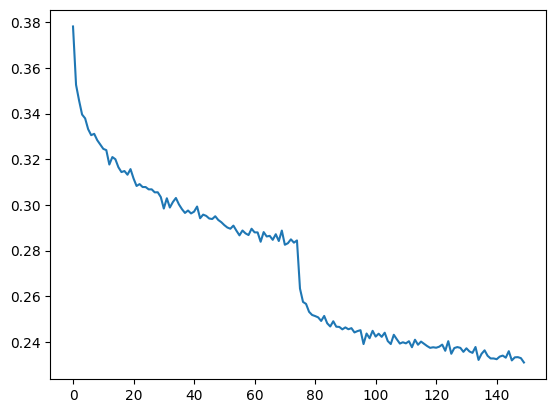

In [213]:
# Visualizations

# Bad plot:
# plt.plot(lossi)

# Better plot:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1)) # averages into buckets of 1000 each

layer 4 (      Gelu): mean +0.24, std 0.70, saturated: 4.07%
layer 8 (      Gelu): mean +0.33, std 0.80, saturated: 5.03%
layer 12 (      Gelu): mean -0.02, std 0.27, saturated: 0.23%


Text(0.5, 1.0, 'activation distribution')

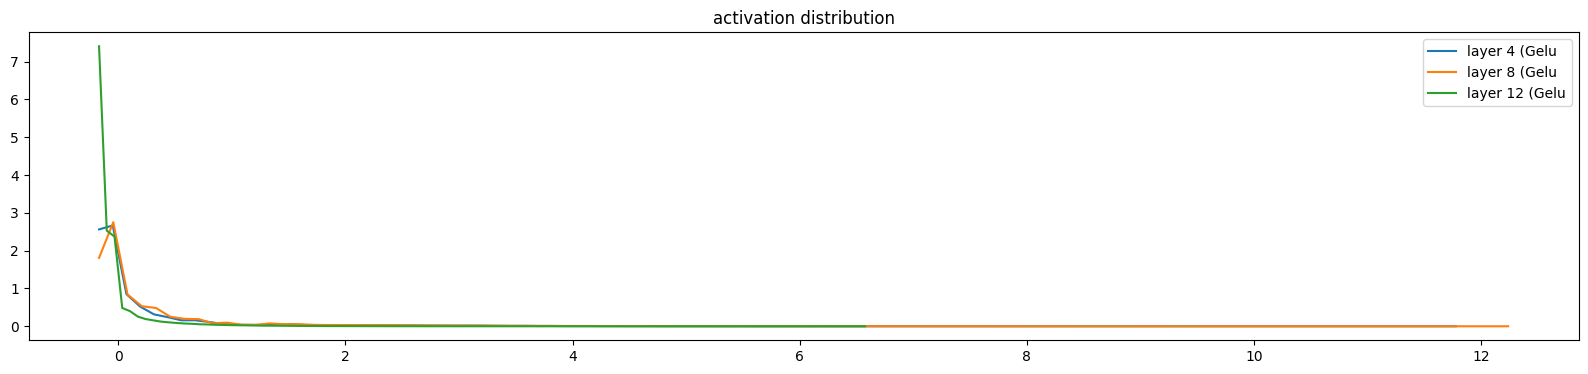

In [214]:
# Check probability distribution for activation function--will look very different from
# tanh because gelu is different.
# Want saturation ~5%

plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Gelu):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), ((t.abs() > 2)).float().mean()*100))
        # ^ slightly modified due to gelu being different from tanh
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight    (27, 8) | mean +0.000000 | std 5.475345e-03, | grad:data ratio: 2.055002e-03
weight  (16, 196) | mean +0.000058 | std 2.871784e-03, | grad:data ratio: 2.943057e-03
weight (392, 196) | mean +0.000004 | std 1.080389e-03, | grad:data ratio: 3.120216e-03
weight (392, 196) | mean +0.000015 | std 1.212462e-03, | grad:data ratio: 3.344714e-03
weight  (196, 27) | mean -0.000000 | std 4.706178e-03, | grad:data ratio: 8.988406e-03


Text(0.5, 1.0, 'weights gradient distribution')

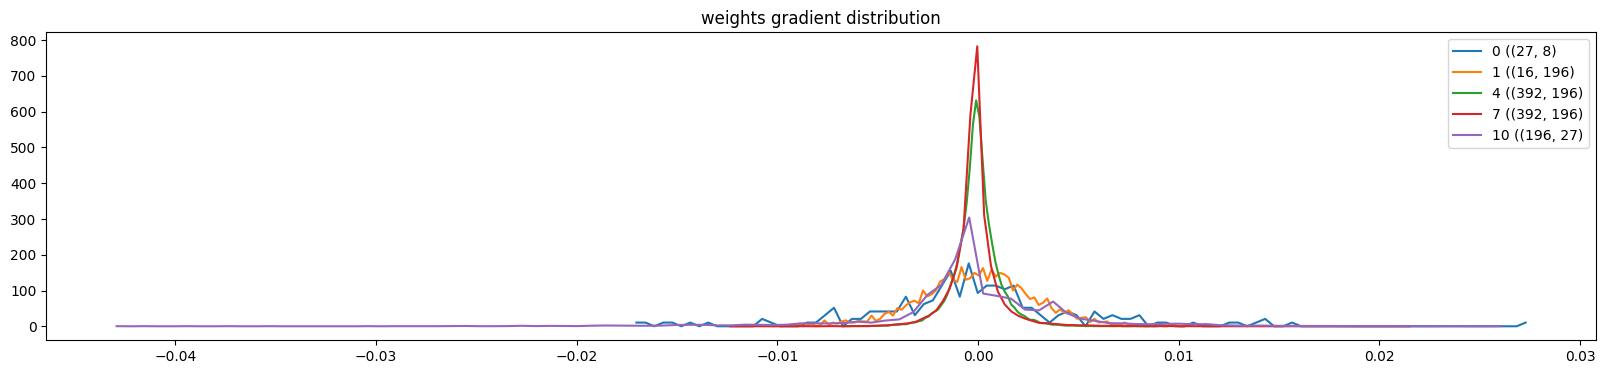

In [215]:
# Backward pass activation statistics
# Want roughly similar gradients to each other; the last layer looks a little funny but the rest are fine
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e, | grad:data ratio: %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution')

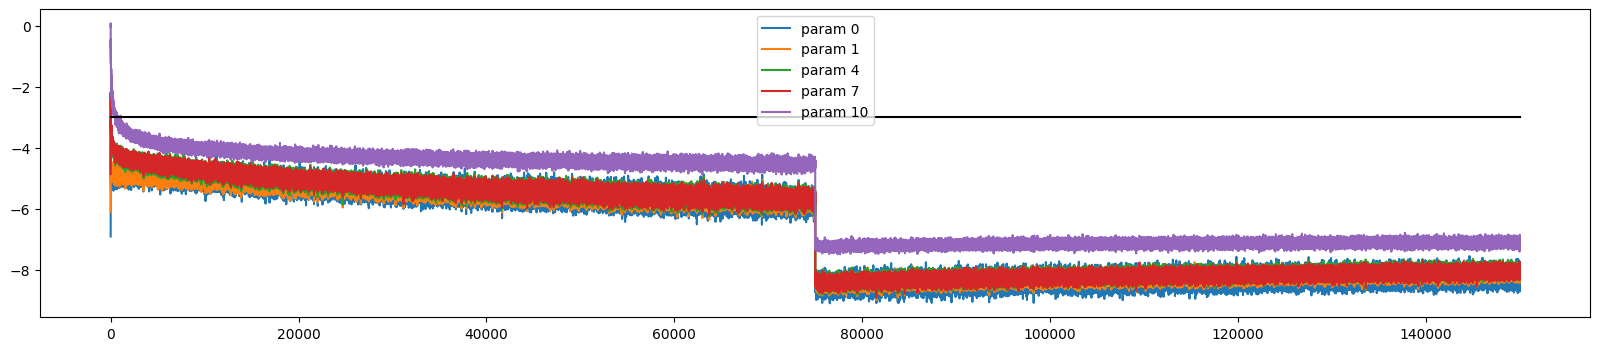

In [216]:
# Plot the training rate--note it should shrink as the training rate shrinks as intended above

plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters): # exclude output layer
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # Ratios should be ~1e-3, heuristically
plt.legend(legends);

In [217]:
# Gamma means should be around 1, betas around 0, std shouldn't be too large
# Running might have larger std though
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, BatchNorm1d):
        print('layer %d (%10s): Gamma: mean %+.2f, std %.2f, Beta: mean %.2f, std %.2f, Running: mean %.2f, std %.2f' % (i, layer.__class__.__name__, layer.gamma.mean(), layer.gamma.std(), layer.beta.mean(), layer.beta.std(), layer.running_mean.mean(), layer.running_var.mean()))


layer 3 (BatchNorm1d): Gamma: mean +1.83, std 0.40, Beta: mean -0.62, std 0.37, Running: mean 3.11, std 44.96
layer 7 (BatchNorm1d): Gamma: mean +2.00, std 0.26, Beta: mean -0.63, std 0.30, Running: mean -2.45, std 72.54
layer 11 (BatchNorm1d): Gamma: mean +0.98, std 0.20, Beta: mean -0.88, std 0.40, Running: mean -4.60, std 60.49


In [218]:
@torch.no_grad() # Disables computing gradients in anticipation of backward pass
def checkloss(X, Y, model):    
    logits = model(X)
    loss = F.cross_entropy(logits, Y) + creativity
    return loss

In [219]:
# Generate from the model:

def generate(num, model, g=None):
    for k in range(num):
        out = []
        context = [0] * block_size
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
    
        print(''.join(itos[i] for i in out))

In [220]:
for layer in model.layers:
    layer.training = False

In [221]:
print(checkloss(Xdev, Ydev, model))

tensor(2.0220)


In [225]:
generate(20, model)

myrika.
ayalee.
rayna.
chayton.
deklin.
jaasiyah.
aleyah.
kelean.
emmilia.
whitley.
alanni.
kallyn.
samira.
aryia.
yshir.
delta.
aalany.
marcelle.
caral.
tylen.


# Part 4: Backprop Ninja

In [42]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182588, 3]) torch.Size([182588])
torch.Size([22852, 3]) torch.Size([22852])
torch.Size([22706, 3]) torch.Size([22706])


In [212]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [213]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [214]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [215]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
loss.retain_grad()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.2356, grad_fn=<NegBackward0>)

In [283]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# LOSS
# How fast does loss change wrt itself? Well, its partial must be 1, because
# a nudge in itself produces an identical nudge in itself.
dloss = torch.tensor(1.0)
# -----------------

# -----------------
# LOGPROBS
# Refresher (for myself) on what we're doing:
# loss = f(logprobs) for some function f.
# know dloss/dloss = 1
# want dloss/dlogprobs
# note: loss = f(logprobs)
# f(x) = -x.mean() = -sum(x) / (32*27)
# f: R^(32x27) -> R
# df: R^(32x27) -> R^(32x27) with entries del z / del (xi,yj) = -1/32*27
# since we do 1/ df, we should have -32*27 in each entry
# 32x27 is col x row notation
# print(logprobs.shape)
# print(Yb.shape)
# print(range(n))a
# print(logprobs[range(n),Yb])
# print(logprobs[range(n),Yb].shape)

# Really, we should break down f into smaller pieces than this:
# h = logprobs[range(n),Yb]: R^32x27 -> R^32, outputting in the kth row the Yb[k]th row entry
# g = -mean(logprobs[range(n),Yb]): R^32 -> R, outputting the mean of all entries
# dh(logprobs)/dlogprobs: TR^32x27 -> TR^32 is a 32x 32x27 tensor: T. T(i,j,k) = 1 if Yb(j) = k else 0
# since logprobs[range(n),Yb] outputs the kth column entry for each of the j rows.
# dg(h(logprobs))/dh(logprobs): TR^32 -> TR is a 1x 32 tensor: T'. T'(i) = -1/32, since we're taking the mean of 32 non-zero entries
# Now, chain rule: dloss/dlogprobs = df(logprobs)/dlogprobs = d(g o h(logprobs))/dlogprobs
# = dg o h(logprobs)/dh(logprobs) * dh(logprobs)/dlogprobs: TR^32x27 -> TR is a 1x 32x27 tensor T''.
# T''(j,k) = -1/32 if Yb(j) = k else 0
# (It helps (me) to recall that the gradient is dual to the total derivative:
# Given (p,v) in TR^n, <grad f(p), v> = delf/delv |_p = df_p(v))
dlogprobs = (-1.0/n) * torch.ones_like(logprobs) * (torch.arange(27).unsqueeze(0) == Yb.unsqueeze(1))

# Karpathy has a much better way of writing it: 
# dlogprobs = torch.zeros_like(logprobs)
# dlogprobs[range(n),Yb] = -1.0/n

# print(dlogprobs)
# -----------------

# -----------------
# PROBS
# dloss / dprobs = dloss / dlogprobs * dlogprobs / dprobs
# dlogprobs / dprobs = dlog(probs)/dprobs = 1/probs
dprobs = 1/probs * dlogprobs
# -----------------

# -----------------
# COUNTS_SUM_INV
# dloss / dcounts_sum_inv = dloss / dlogprobs * dlogprobs / dprobs * dprobs / dcounts_sum_inv
# probs = counts * counts_sum_inv
# dprob/dcounts_sum_inv = counts 
# dcounts_sum_inv = dprobs * counts? Why no work? Hmmm...
# Well, in 1D, if f(x) = cx, then df/dx = c. But now f: R^(32x 32x27) -> R^(32x27) is given by f(x,y) = y*x
# ...
# Watched a bit of the Karpathy video to figure it out. Damned broadcasting! 
# Convenient, sure, but doesn't make my math brain happy.
# Ok, so we want to turn counts_sum_inv: 32x1 into counts_sum_inv: 32x27:
# counts * counts_sum_inv = counts * counts_sum_inv.unsqueeze(1).expand(32, 27)
# which means for each row, we sum all of the values in counts of that row together
# meaning the derivative is equal to the sum of those values:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# (had to watch the Karpathy video to get the keepdim=True part...)
# -----------------

# -----------------
# COUNTS_SUM
# dcounts_sum_inv/dcounts_sum = df/dx f(x) = 1/x, df = -1/x^2
dcounts_sum = -1/(torch.square(counts_sum)) * dcounts_sum_inv
# -----------------

# -----------------
# COUNTS
# dcounts_sum_inv/dcounts = dcounts_sum_inv/dcounts_sum * dcounts_sum/dcounts
# Initialize each column of dcounts as just ones times 
# probs = counts * counts_sum_inv
# dprob/dcounts = counts * dcounts_sum_inv/dcounts + dcounts * counts_sum_inv
dcounts = torch.ones_like(counts) * dcounts_sum + counts_sum_inv*dprobs # do .ones because dcounts/dcounts = 1
# -----------------

# -----------------
# NORM_LOGITS
dnorm_logits = counts * dcounts
# -----------------

# -----------------
# LOGIT_MAXES
# norm_logits = logits - logit_maxes
# reminder of what we're doing:
# want: dloss/dlogit_maxes.
# have: dloss/dnorm_logits
# dloss/dlogit_maxes = dloss/dnorm_logits * dnorm_logits/dlogit_maxes
# dnorm_logits/dlogit_maxes = -1
# More broadcasting bullshit. norm_logits 32x27 = logits 32x27 - logit_maxes 32x1
# is really norm_logits = logits - logit_maxes.expand(32,27)
# so it's really:
dlogit_maxes = -dnorm_logits.sum(1,keepdim=True)
# -----------------

# -----------------
# LOGITS
# logits_maxes = logits.max(1,keepdim=True).values
# dloss/dlogits = dloss/dnorm_logits * dnorm_logits/dlogits
# dnorm_logits/dlogits = d(logits - logit_maxes)/dlogits = dlogits/dlogits - dlogit_maxes.expand(32,27)/dlogits
# dlogit_maxes/dlogits: TR^32x27 -> TR^32x27, should be = 1 if max value in row else 0
dlogits = dnorm_logits + dlogit_maxes*(logits == logit_maxes)
# -----------------

# -----------------
# h, W2, b2
# Woohoo! Made it thru cross-entropy / softmax! 
# print(h.shape)
# print(logits.shape)
# print(W2.shape)
# print(b2.shape)
# ah, so I think here, @ is just regular matrix multiplication
# dloss/dh = dloss/dlogits * dlogits/dh
# logits = h @ W2 + b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
# print(dh.shape)
# print(dW2.shape)
# print(db2.shape)
# Important question: What is this layer? This is the output layer prior to softmaxing
# -----------------

# -----------------
# HPREACT
# dloss/dhpreact = dloss/dh * dh/dhpreact
#dh/dhpreact = dtanh(hpreact)/dhpreact
# dtanh(x) = d/dx (e^x - e^-x)* 1/(e^x + e^-x) = (e^x + e^-x) * 1/(e^x + e^-x) + (e^x - e^-x) * -(e^x - e^-x)/(e^x + e^-x)^2 
# = 1 - ((e^x - e^-x)/(e^x + e^-x))^2 = 1 - tanh(x)^2
dhpreact = dh * (1 - torch.tanh(hpreact)**2)
# oops, Karpathy writes it better:
# dhpreact = (1 - h**2) * dh
# for some reason, I get an approximate answer instead of an exact one, despite being identical to Karpathy...
# -----------------

# -----------------
# BN
# hpreact = bngain * bnraw + bnbias
# dloss/dbngain = dloss/dhpreact * dhpreact/dbngain
# print(hpreact.shape)
# print(bngain.expand(64,64).shape)
# print(bnraw.shape)
# print(bnbias.expand(32,64).shape)
# bngain is broadcast: 1,64 -> 64x64, bnbias is broadcast: 1,64 -> 32x64
# hpreact = bnraw @ bngain.expand(64,64) + bnbias.expand(32,64)
dbngain = (dhpreact * bnraw).sum(0,keepdim=True)
#dloss/dbnbias = dloss/dhpreact * dhpreact/dbnbias
dbnbias = dhpreact.sum(0,keepdim=True)
#dloss/dbnbias = dloss/dhpreact * dhpreact/dbnraw
dbnraw = dhpreact * bngain


# bnraw = bndiff * bnvar_inv
# dloss/dbnvar_inv = dloss/dbnraw * dbnraw/dbnvar_inv
# dloss/dbndiff = dloss/dbnraw * dbnraw/dbndiff
# print(bndiff.shape)
# print(bnvar_inv.shape)
# print(bnraw.shape)
# bnvar_inv is broadcast: 1,64 -> 64x64
dbnvar_inv = (dbnraw * bndiff).sum(0,keepdim=True)
# dbndiff = dbnraw * bnvar_inv
# bnvar_inv = (bnvar + 1e-5)**-0.5
# d/dbnvar bnvar_inv = -0.5*(bnvar + 1e-5)**-1.5
dbnvar = dbnvar_inv * -0.5*(bnvar + 1e-5)**-1.5
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
dbndiff2 = 1/(n-1) * dbnvar.expand(dbndiff2.shape)
# bndiff2 = bndiff**2
#dloss/dbndiff = dloss/dbnraw * dbnraw/dbndiff
# dbnraw/dbndiff = bnvar_inv + bndiff*dbnvar_inv/dbndiff
dbndiff = dbnraw * bnvar_inv + 2*bndiff*dbndiff2
# -----------------

# -----------------
# PRE-BN
# bndiff = hprebn - bnmeani
# print(bndiff.shape)
# print(bnmeani.shape)
# print(hprebn.shape)
# bnmeani is broadcast: 1,64 -> 32,64
# bndiff = hprebn - bnmeani
#
# dhprebn = dbndiff
dbnmeani = -dbndiff.sum(0,keepdim=True)
# dloss/dhprebn = dloss/dbndiff * dbndiff/dhprebn = dloss/dbndiff * (dhprebn/dhprebn - dbnmeani/dhprebn)
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# dbnmeani/dhprebn: 1/n*dbnmeani.expand(32,64)
dhprebn = dbndiff * torch.ones_like(dhprebn) + 1/n*dbnmeani.expand(dhprebn.shape)
# -----------------

# -----------------
# EMBEDDING
# emb = C[Xb] # embed the characters into vectors
# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# # Linear layer 1
# hprebn = embcat @ W1 + b1 # hidden layer pre-activation
print(hprebn.shape)
print(embcat.shape)
print(W1.shape)
print(b1.shape)
# b1 is broadcast: 64 -> 1,64 -> 32,64
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

# Now wtf is embcat again?
print(emb.shape)
# embcat takes a 32x3x10 tensor as input and outputs a 32x30 tensor: emb(i,j,k) -> emb(i,j*10+k)
# so the backprob should essentially be 1-to-1, just un-viewed appropriately: embcat(i,j) -> emb(i,j//10,j%10)
demb = dembcat.view(emb.shape[0],emb.shape[1],emb.shape[2])

# What is C again? It's the actual space of learned embeddings of the 27 characters into a 10-dim space.
print(C.shape)
print(Xb.shape)
# so emb: (27,10) x (32,3) -> (32,3,10)
# by taking emb(i,j,k) = C(Xb(i,j),k) for a character Xb(i,j) equal to a value between 0 and 26
# so demb(i,j,k) = dC(Xb(i,j),k)
# Dude I was so upset that I couldn't figure out how to do this with clever broadcasting,
# then I watched Karpathy and saw he just used for loops. Ok thanks!
dC = torch.zeros_like(C)
for i in range(0,Xb.shape[0]):
    for j in range(0,Xb.shape[1]):
        dC[Xb[i,j]] += demb[i,j]
# -----------------



# Adding one extra line: Change in loss wrt itself is 1
cmp('loss', dloss, loss)
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

torch.Size([32, 64])
torch.Size([32, 30])
torch.Size([30, 64])
torch.Size([64])
torch.Size([32, 3, 10])
torch.Size([27, 10])
torch.Size([32, 3])
loss            | exact: True  | approximate: True  | maxdiff: 0.0
logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True 

In [287]:
# Exercises 2,3: Meh I feel like I don't have to do them it's just simplifying the math expressions;
# I'll shamelessly disobey Karpathy's instructions and copy his simplified expressions. 
# Fuck that shit! I've broken the complicated thing down into simple pieces. I get it. Anything else is just being
# messier about it.
# Nvm I see Karpathy's simplifications. That's nice, but still hiding the complexity behind a different complicated function!
# Meh. I'm fine with this.

In [286]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  # loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
    dlogits = F.softmax(logits,1)
    dlogits[range(n),Yb] -= 1
    dlogits /= n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = dh * (1 - torch.tanh(hpreact)**2)

    dbngain = (bnraw * dhpreact).sum(0,keepdim=True)
    dbnbias = dhpreact.sum(0,keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    
    dembcat = dhprebn @ W1.TdW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    demb = dembcat.view(emb.shape[0],emb.shape[1],emb.shape[2])
    dC = torch.zeros_like(C)
    for i in range(0,Xb.shape[0]):
        for j in range(0,Xb.shape[1]):
            dC[Xb[i,j]] += demb[i,j]

  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

torch.Size([32])